<a href="https://colab.research.google.com/github/linesn/reddit_analysis/blob/main/Facebook_impression_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Facebook post impressions
Nicholas Lines

This notebook is my work for Module 8 of EN.605.633.81.SP21 Social Media Analytics.  
The problem prompt is  
> Design a supervised machine learning classifier that will predict whether the impression of Facebook posts will be greater than 1,000 based on data such as the type of post, weekday or weekend, and weather. Implement the classifier and test it using Python. The data corpus contains data from Facebook on recent posts for a bicycle shop. The columns are Post Message, Message Type, Date and Time of Post, Number of Impression, Weather indicator for snow or rain, and weekday or weekend indicator for the post.  
> Test your classifier and calculate precision and recall. Turn in Python code for the classifier

The data used was provided by the instructor.

## Environment setup
I'll try to use `scikit-learn` built-in functions and structures wherever possible for consistency and ease of review.

In [1]:
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [4]:
if 'COLAB_GPU' in os.environ: # a hacky way of determining if you are in colab.
  print("Notebook is running in colab")
  from google.colab import drive
  drive.mount("/content/drive")
  DATA_DIR = "./drive/My Drive/Data/"
  
else:
  # Get the system information from the OS
  PLATFORM_SYSTEM = platform.system()

  # Darwin is macOS
  if PLATFORM_SYSTEM == "Darwin":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver")
  elif PLATFORM_SYSTEM == "Windows":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver.exe")
  else:
      logging.critical("Chromedriver not found or Chromedriver is outdated...")
      exit()
  DATA_DIR = "../Data/"

Notebook is running in colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data read-in and feature review

In [5]:
df = pd.read_excel(DATA_DIR + "raw/SocialMediaInsightsforMachineLearning.xlsm", parse_dates=True)

In [6]:
df = df.drop(101)

In [7]:
df

,Post Message,Type,Posted,Impressions,Weather,Weekend
0,"Dont forget, our Spring Savings Event is going...",Photo,2016-03-03 03:13:12,1220.0,Snow,N
1,https://www.facebook.com/natalie.birner/posts/...,SharedVideo,2016-03-03 06:05:04,165.0,Snow,N
2,Got a new bike in the last year or so and look...,Photo,2016-03-04 12:25:06,1398.0,Snow,Y
3,Just in! New HiVis Endura jerseys and riding s...,Photo,2016-03-04 13:16:22,1174.0,Snow,Y
4,Sale ends March 31,Photo,2016-03-04 14:19:07,1030.0,Snow,Y
...,...,...,...,...,...,...
96,Our Saturday morning road ride leaves the shop...,Status,2016-07-08 15:15:18,69.0,Rain,Y
97,Gear up for adventurous rides with our 40% Off...,Photo,2016-07-14 09:42:20,1515.0,Thunder,N
98,Some of our employees took an awesome trip dow...,Photo,2016-07-14 15:43:05,291.0,Thunder,N
99,Our Saturday morning road ride leaves the shop...,Status,2016-07-15 14:51:38,89.0,NaN,Y


In [8]:
print(f"There are {df.shape[0]} data points and {df.shape[1]} columns")

There are 101 data points and 6 columns


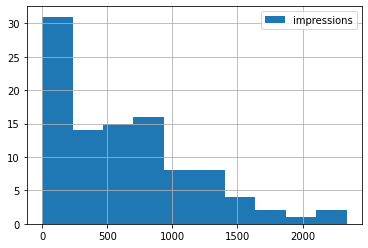

In [9]:
df.Impressions.hist(label="impressions");
legend();

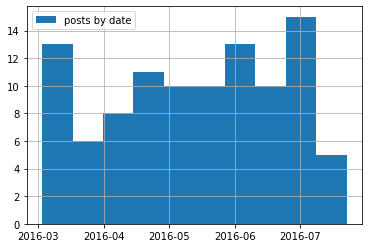

In [10]:
df.Posted.hist(label="posts by date")
legend();

Let's do some gentle feature engineering, using one-hot or dummy encoding to represent categorical data, and extracting a few features from the post body, extract time of day from the post time, etc.

In [11]:
df['num_hashtags'] = df["Post Message"].str.count("#") # check if the hash symbol is used
df['post_length'] = df["Post Message"].str.len() # get the length of the string
df['contains_link'] = (df["Post Message"].str.count("http") +  df["Post Message"].str.count("www")).astype(bool).astype(int) # check if http or www are used in the string
df['Time'] = df.Posted.dt.hour * 60 + df.Posted.dt.minute

In [12]:
Types_df = pd.get_dummies(df.Type, prefix='Type')
Weather_df = pd.get_dummies(df.Weather, prefix='Weather')
Weekend_df = pd.get_dummies(df.Weekend, prefix='Weekend', drop_first=True)
df = pd.concat([df, Types_df, Weather_df, Weekend_df], axis=1)

In [13]:
df.head()

,Post Message,Type,Posted,Impressions,Weather,Weekend,num_hashtags,post_length,contains_link,Time,Type_Link,Type_Photo,Type_SharedVideo,Type_Status,Type_Video,Weather_Rain,Weather_Snow,Weather_Thunder,Weekend_Y
0,"Dont forget, our Spring Savings Event is going...",Photo,2016-03-03 03:13:12,1220.0,Snow,N,11,178,0,193,0,1,0,0,0,0,1,0,0
1,https://www.facebook.com/natalie.birner/posts/...,SharedVideo,2016-03-03 06:05:04,165.0,Snow,N,0,63,1,365,0,0,1,0,0,0,1,0,0
2,Got a new bike in the last year or so and look...,Photo,2016-03-04 12:25:06,1398.0,Snow,Y,0,185,0,745,0,1,0,0,0,0,1,0,1
3,Just in! New HiVis Endura jerseys and riding s...,Photo,2016-03-04 13:16:22,1174.0,Snow,Y,9,183,0,796,0,1,0,0,0,0,1,0,1
4,Sale ends March 31,Photo,2016-03-04 14:19:07,1030.0,Snow,Y,0,18,0,859,0,1,0,0,0,0,1,0,1


Now that we have some numeric features to work with, let's just check which are most strongly corrolated with Impressions:

In [14]:
df.corr()

,Impressions,num_hashtags,post_length,contains_link,Time,Type_Link,Type_Photo,Type_SharedVideo,Type_Status,Type_Video,Weather_Rain,Weather_Snow,Weather_Thunder,Weekend_Y
Impressions,1.000000,0.226830,0.010117,0.011151,-0.129586,0.053028,0.480979,-0.138842,-0.524618,-0.034063,0.059085,0.081404,0.073539,-0.355357
num_hashtags,0.226830,1.000000,0.280402,-0.097285,-0.011937,-0.097285,0.246692,-0.044210,-0.173652,-0.063163,0.107415,0.181358,-0.044210,-0.204155
post_length,0.010117,0.280402,1.000000,-0.041782,0.008921,-0.097729,-0.038413,-0.052765,0.188989,-0.136099,-0.046559,0.060374,0.117213,0.013981
contains_link,0.011151,-0.097285,-0.041782,1.000000,0.021759,0.634058,-0.251598,0.204989,-0.174617,-0.063514,-0.154736,0.188316,-0.044455,-0.024524
Time,-0.129586,-0.011937,0.008921,0.021759,1.000000,0.099101,-0.164477,-0.153325,0.194576,-0.049284,0.015589,-0.137687,0.065646,0.059361
Type_Link,0.053028,-0.097285,-0.097729,0.634058,0.099101,1.000000,-0.394358,-0.044455,-0.174617,-0.063514,-0.008677,0.051482,-0.044455,-0.024524
Type_Photo,0.480979,0.246692,-0.038413,-0.251598,-0.164477,-0.394358,1.000000,-0.179209,-0.703921,-0.256040,-0.106204,0.056288,0.112729,-0.158677
Type_SharedVideo,-0.138842,-0.044210,-0.052765,0.204989,-0.153325,-0.044455,-0.179209,1.000000,-0.079352,-0.028863,-0.103505,0.241031,-0.020202,-0.027224
Type_Status,-0.524618,-0.173652,0.188989,-0.174617,0.194576,-0.174617,-0.703921,-0.079352,1.000000,-0.113372,0.131163,-0.152351,-0.079352,0.224655
Type_Video,-0.034063,-0.063163,-0.136099,-0.063514,-0.049284,-0.063514,-0.256040,-0.028863,-0.113372,1.000000,0.065489,-0.055415,-0.028863,-0.038896


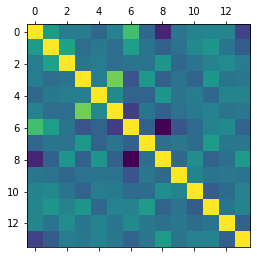

In [15]:
matshow(df.corr());

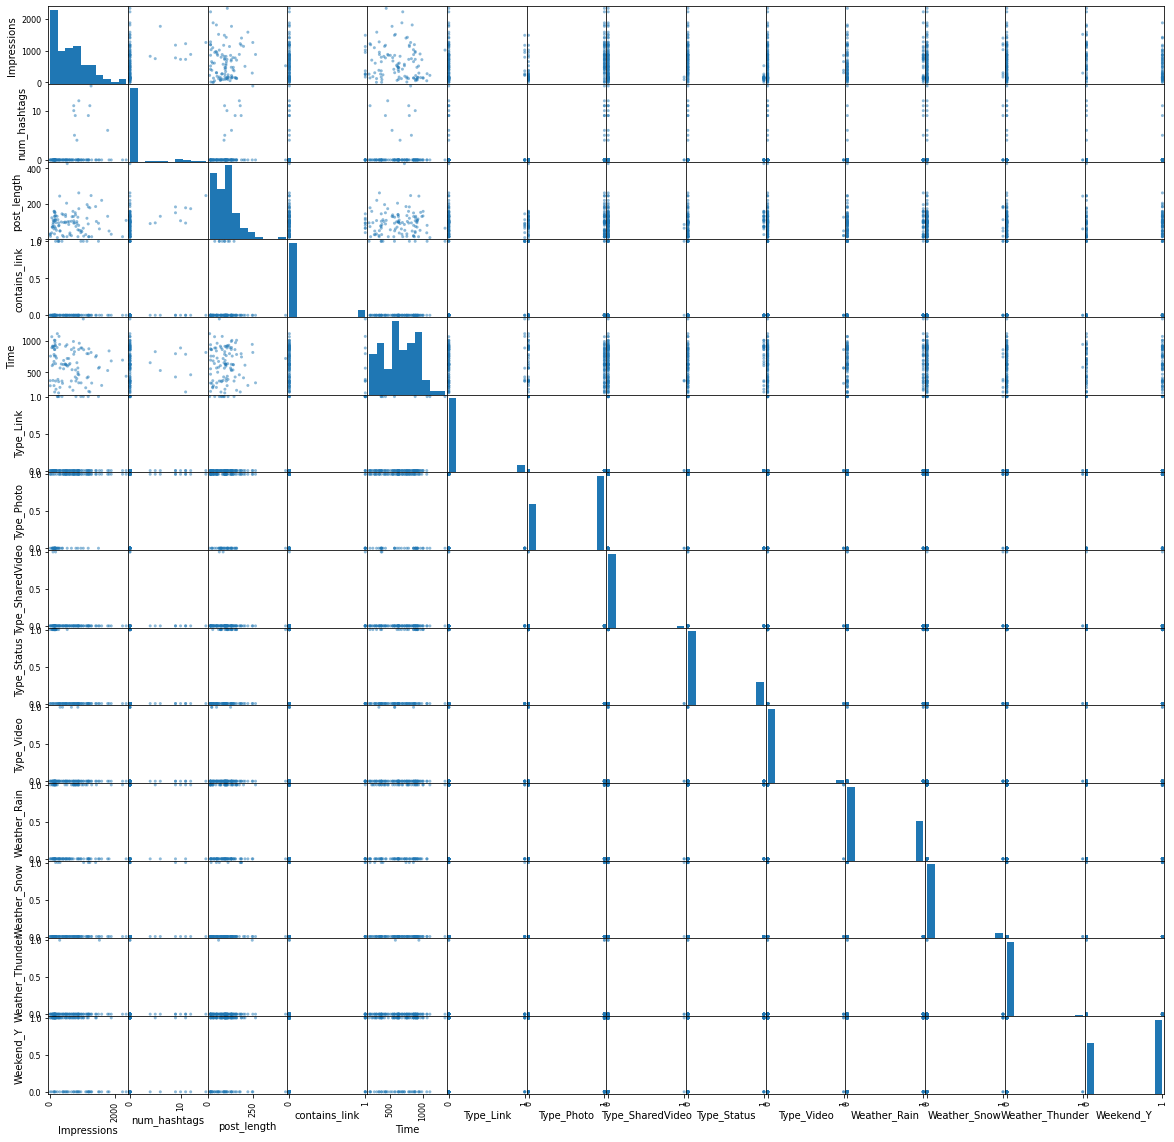

In [16]:
pd.plotting.scatter_matrix(df, figsize=(20,20));

It is clear that we want to include post type data in our decision, as well as post length and time of posting, as a minimum. 

## Setting up training/test data

In [17]:
X = df[["num_hashtags", 
    "post_length", 
    "Time", 
    "Type_Link", 
    "Type_Photo", 
    "Type_SharedVideo", 
    "Type_Status",
    "Type_Video",
    "Weather_Rain", 
    "Weather_Snow",
    "Weather_Thunder",
    "Weekend_Y"]].to_numpy()
y = (df[["Impressions"]] > 1000).astype(int).to_numpy().flatten()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train and test classifiers
I'll throw a bunch of non-optimized standard classifiers at the data. In particular, I'll try Gradient boosting, Random forests, a Multi-layered Perceptron, a Support Vector Machine, K-nearest neighbors, and an ensemble.

In [20]:
clf0 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
clf3 = GaussianNB()
clf4 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf5 = SVC()
clf6 = DecisionTreeClassifier()
clf7 = KNeighborsClassifier()
eclf = VotingClassifier(
     estimators=[
                 #('gb', clf0),
                 #('lr', clf1), 
                 ('rf', clf2), 
                 ('gnb', clf3),
                 ('mlp', clf4),
                 ('svm', clf5),
                 ('dt', clf6),
                 ],
     voting='hard')

Gradient Boosting: 
Accuracy: 0.52 (+/- 0.19) [Gradient Boosting]
Precision score: 0.4
Recall score: 0.13333333333333333
Average precision-recall score: 0.37


Random Forest: 
Accuracy: 0.66 (+/- 0.12) [Random Forest]
Precision score: 0.6666666666666666
Recall score: 0.13333333333333333
Average precision-recall score: 0.41


naive Bayes: 
Accuracy: 0.59 (+/- 0.11) [naive Bayes]
Precision score: 0.4782608695652174
Recall score: 0.7333333333333333
Average precision-recall score: 0.45


Multi Layered Perceptron: 
Accuracy: 0.63 (+/- 0.02) [Multi Layered Perceptron]
Precision score: 0.0
Recall score: 0.0
Average precision-recall score: 0.37




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Machine: 
Accuracy: 0.63 (+/- 0.02) [Support Vector Machine]
Precision score: 0.0
Recall score: 0.0
Average precision-recall score: 0.37


Decision Tree Classifier: 
Accuracy: 0.63 (+/- 0.11) [Decision Tree Classifier]
Precision score: 0.375
Recall score: 0.2
Average precision-recall score: 0.37


K Nearest Neighbors Classifier: 
Accuracy: 0.51 (+/- 0.11) [K Nearest Neighbors Classifier]
Precision score: 0.0
Recall score: 0.0
Average precision-recall score: 0.37


Ensemble: 
Accuracy: 0.64 (+/- 0.06) [Ensemble]


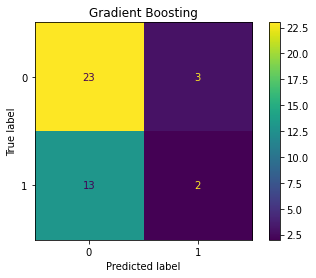

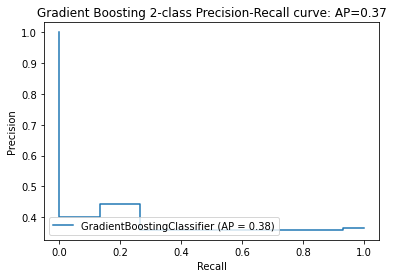

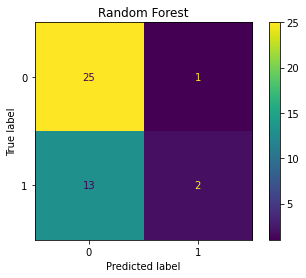

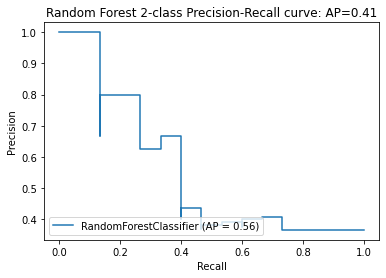

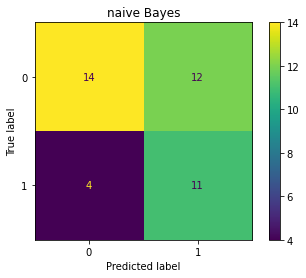

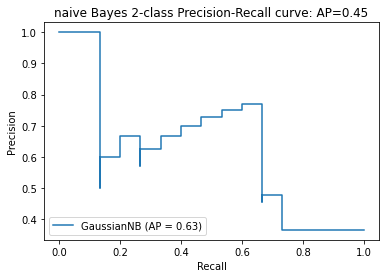

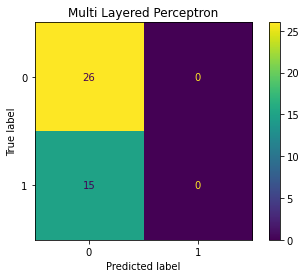

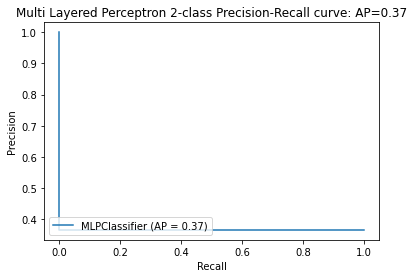

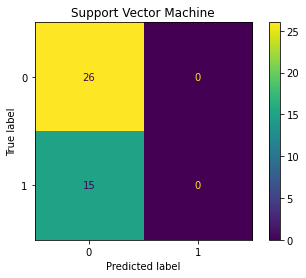

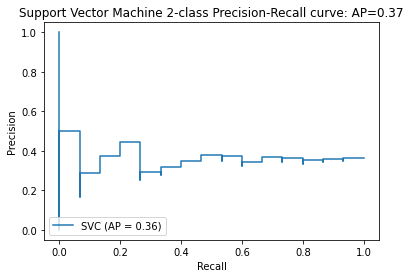

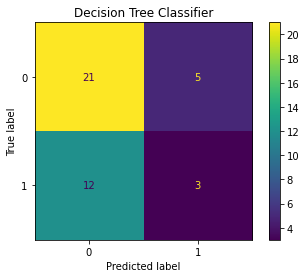

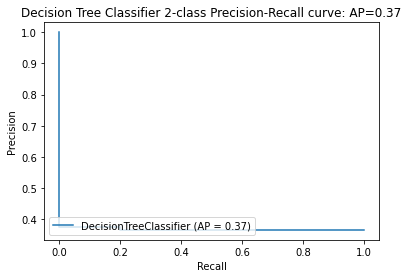

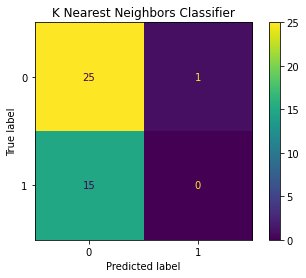

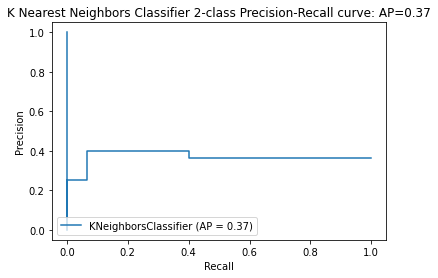

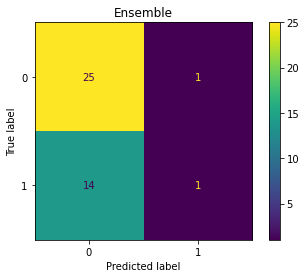

In [21]:
for clf, label in zip([
                       clf0,
                       #clf1, 
                       clf2, 
                       clf3,
                       clf4,
                       clf5, 
                       clf6,
                       clf7,
                       eclf,
                       ], [
                           'Gradient Boosting',
                           #'Logistic Regression', 
                           'Random Forest', 
                           'naive Bayes', 
                           'Multi Layered Perceptron',
                           'Support Vector Machine',
                           'Decision Tree Classifier',
                           'K Nearest Neighbors Classifier',
                           'Ensemble']):
  clf.fit(X_train, y_train)
  plot_confusion_matrix(clf, X_test, y_test) 
  plt.title(label)
  scores = cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=5)
  print(label + ": ")
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
  if not label=="Ensemble": # the decision function isn't defined in that case
    y_pred = clf.predict(X_test)
    print(f"Precision score: {precision_score(y_test, y_pred)}")
    print(f"Recall score: {recall_score(y_test, y_pred)}")
    average_precision = average_precision_score(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title(label + ' 2-class Precision-Recall curve: '
                        'AP={0:0.2f}'.format(average_precision))
    print("\n")

Well, it appears that these classifiers aren't very good. The random forest is the only one that I trust at all, since it is actually making a non-trivial choice that is consistently better than guessing. The small sample size probably means that we won't get very high accuracy no matter how clever we are in our feature engineering and classifier choice and design.